# Taiwan ETF Price Prediction

Import some useful model

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('expand_frame_repr', True)

Populating the interactive namespace from numpy and matplotlib


Import the ETF trade history data

In [75]:
#set the path of file
tetfp_path = 'C:/Users/AdamChang/Documents/Documents/PFD/Porfolio/T-Brain ETF Compitition/TBrain_Round2_DataSet_20180331/tetfp.csv'

# read the data
tetfp = pd.read_csv(tetfp_path, encoding='big5',
                    names=['Code','Date','Company','Open','High','Low','Close','Volumn'],skiprows=1)

## Overview the data

In [76]:
# View the top 5 of the data
tetfp.head()

,Code,Date,Company,Open,High,Low,Close,Volumn
0,50,20130102,元大台灣50,54.00,54.65,53.90,54.40,"16,487"
1,50,20130103,元大台灣50,54.90,55.05,54.65,54.85,"29,020"
2,50,20130104,元大台灣50,54.85,54.85,54.40,54.50,"9,837"
3,50,20130107,元大台灣50,54.55,54.55,53.90,54.25,"8,910"
4,50,20130108,元大台灣50,54.00,54.20,53.65,53.90,"12,507"


In [77]:
# View the company in the data
tetfp['Company'].value_counts()

元大富櫃50               1286
元大高股息                1286
元大MSCI金融             1286
元大台灣50               1286
元大MSCI台灣             1286
富邦科技                 1286
元大電子                 1286
富邦金融                 1286
富邦發達                 1286
富邦台50                1286
元大台商50               1286
富邦摩台                 1286
永豐臺灣加權               1286
元大中型100              1286
兆豐藍籌30                248
富邦公司治理                218
國泰臺灣低波動30             153
元大台灣高息低波              124
Name: Company, dtype: int64

In [78]:
# Check the daya type
tetfp.dtypes

Code         int64
Date         int64
Company     object
Open       float64
High       float64
Low        float64
Close      float64
Volumn      object
dtype: object

In [79]:
#View the basic statistic imformation in the data
tetfp.describe()

,Code,Date,Open,High,Low,Close
count,18747.000000,1.874700e+04,18747.000000,18747.000000,18747.000000,18747.000000
mean,1767.316744,2.015285e+07,32.771099,32.870491,32.659272,32.762544
std,2731.201524,1.545531e+04,14.025141,14.063900,13.984771,14.026127
min,50.000000,2.013010e+07,9.300000,9.710000,9.240000,9.250000
25%,53.000000,2.014052e+07,23.385000,23.480000,23.285000,23.390000
50%,57.000000,2.015092e+07,31.550000,31.650000,31.450000,31.520000
75%,6201.000000,2.017021e+07,39.820000,39.915000,39.700000,39.800000
max,6208.000000,2.018033e+07,88.050000,88.400000,87.900000,88.300000


## Data Feature Engineering

Make some new features in the data:
1. Get the date part from the data: Year, Month, Day, DayOfWork, Season, Week
2. High, Low, Open, Close price and Volumn in the yesterday
3. Get the fluctuation of the price in the yesterday: 2 days before of close price - close price in the yesterday
4. The range in yesterday: High - Low
5. Rise or down of the price: rise(1) & down(-1) & none(0)
6. The max and min close price in the history
7. The range of close price in the history
8. Rise or down of the history range: rise(1) & none(0)
9. Rise or down of the range in the yesterday: rise(1) & none(0) & down(-1)
10. The fluctuation of the volumn in the yesterday
11. Rise of down of the volumn in the yesterday: rise(1) & none(0) & down(-1)
12. 5, 10, 20, 60, 120 days moving average of the High, Low, Close, Open, Volumn
13. 5, 10, 20, 60, 120 days moving sum of the volumn 

In [80]:
#Choose one ETF
tetfp1 = tetfp[tetfp.Code == 50].copy().reset_index()
#Append the last data for next day prediction
new = pd.DataFrame(tetfp1[-1:].values,index=[tetfp1['Code'].count()],columns=tetfp1.columns)
tetfp1 = tetfp1.append(new)

#Change the format of the date
tetfp1['Date'] = pd.to_datetime(tetfp1['Date'],format='%Y%m%d')

In [81]:
tetfp1.head()

,index,Code,Date,Company,Open,High,Low,Close,Volumn
0,0,50,2013-01-02,元大台灣50,54,54.65,53.9,54.4,"16,487"
1,1,50,2013-01-03,元大台灣50,54.9,55.05,54.65,54.85,"29,020"
2,2,50,2013-01-04,元大台灣50,54.85,54.85,54.4,54.5,"9,837"
3,3,50,2013-01-07,元大台灣50,54.55,54.55,53.9,54.25,"8,910"
4,4,50,2013-01-08,元大台灣50,54,54.2,53.65,53.9,"12,507"


In [82]:
#Change the Code datatype
tetfp1['Code'] = tetfp1['Code'].astype('object')

In [83]:
#Check the volumn data
tetfp1.loc[1,'Volumn']

'     29,020'

In [84]:
#Process the datatype of the volumn data
for i in range(tetfp1['Volumn'].count()):
    a = tetfp1.loc[i,'Volumn'].split(',')
    b=''
    for j in a:
        b=b+j
    tetfp1.loc[i,'Volumn']=b
tetfp1['Volumn'] = tetfp1['Volumn'].astype('float64')

In [85]:
#Get the date part of the date
tetfp1['Year'] = tetfp1['Date'].dt.year
tetfp1['Month'] = tetfp1['Date'].dt.month
tetfp1['Day'] = tetfp1['Date'].dt.day
tetfp1['Dayofwork'] = tetfp1['Date'].dt.dayofweek
tetfp1['Week'] = tetfp1['Date'].dt.week

In [86]:
#Get the season
tetfp1['Season'] = 'nan'
for i in range(tetfp1.Season.count()):
    if tetfp1.loc[i,'Month'] in [1,2,3]:
        tetfp1.loc[i,'Season'] = 1
    elif tetfp1.loc[i,'Month'] in [4,5,6]:
        tetfp1.loc[i,'Season'] = 2
    elif tetfp1.loc[i,'Month'] in [7,8,9]:
        tetfp1.loc[i,'Season'] = 3
    else:
        tetfp1.loc[i,'Season'] = 4

In [87]:
#Shift the date of price
tetfp1['Open1DayShift'] = tetfp1['Open'].shift(1)
tetfp1['High1DayShift'] = tetfp1['High'].shift(1)
tetfp1['Low1DayShift'] = tetfp1['Low'].shift(1)
tetfp1['Close1DayShift'] = tetfp1['Close'].shift(1)
tetfp1['Volumn1DayShift'] = tetfp1['Volumn'].shift(1)

In [88]:
#Calculate the range and fluctuation
tetfp1['Close2DayShift'] = tetfp1['Close'].shift(2)
tetfp1['Fluctuation'] = tetfp1['Close1DayShift'] - tetfp1['Close2DayShift']

#Calculate the range yesterday
tetfp1['YesterdayRange'] = tetfp1['High1DayShift'] - tetfp1['Low1DayShift']

In [89]:
#fill the shift nan data
tetfp1 = tetfp1.fillna(method = 'bfill')

In [90]:
#Calculate the fluctuation
tetfp1['RiseOrDown'] = 'nan'
for i in range(tetfp1['Fluctuation'].count()):
    if tetfp1.loc[i,'Fluctuation']==0:
        tetfp1.loc[i,'RiseOrDown'] = 0
    elif tetfp1.loc[i,'Fluctuation']>0:
        tetfp1.loc[i,'RiseOrDown'] = 1
    else:
        tetfp1.loc[i,'RiseOrDown']=-1

In [91]:
#Select history information
pmax = tetfp1.loc[0,'Close1DayShift']
pmin = tetfp1.loc[0,'Close1DayShift']
tetfp1['HistoryMax'] = 'nan'
tetfp1['HistoryMin'] = 'nan'
for i in range(tetfp1['HistoryMax'].count()):
    if tetfp1.loc[i,'Close1DayShift'] > pmax:
        pmax = tetfp1.loc[i,'Close1DayShift']
    tetfp1.loc[i,'HistoryMax'] = pmax
    if tetfp1.loc[i,'Close1DayShift'] < pmin:
        pmin = tetfp1.loc[i,'Close1DayShift']
    tetfp1.loc[i,'HistoryMin'] = pmin

In [92]:
#Calculate the history range
tetfp1['HistoryRange'] = tetfp1['HistoryMax'] - tetfp1['HistoryMin']

In [93]:
#Overview the history range
tetfp1['HistoryRangeRise'] = 0
for i in range(tetfp1['HistoryRange'].count()):
    if (i-1)>0:
        if tetfp1.loc[i,'HistoryRange']>tetfp1.loc[i-1,'HistoryRange']:
            tetfp1.loc[i,'HistoryRangeRise'] = 1
            
#Overview the yesterday range
tetfp1['YesterdayRangeRise'] = 0
for i in range(tetfp1['YesterdayRange'].count()):
    if (i-1)>0:
        if tetfp1.loc[i,'YesterdayRange']>tetfp1.loc[i-1,'YesterdayRange']:
            tetfp1.loc[i,'YesterdayRangeRise'] = 1
        elif tetfp1.loc[i,'YesterdayRange']<tetfp1.loc[i-1,'YesterdayRange']:
            tetfp1.loc[i,'YesterdayRangeRise'] = -1

In [94]:
#Calculate the volumn change
tetfp1['Volumn2DayShift'] = tetfp1['Volumn'].shift(2)
tetfp1['VolumnFluctuation'] = tetfp1['Volumn1DayShift'] - tetfp1['Volumn2DayShift']

In [95]:
#Calculate the volumn rise or down
tetfp1 = tetfp1.fillna(method='bfill')
tetfp1['VolumnRise'] = 0
for i in range(tetfp1['VolumnRise'].count()):
    if tetfp1.loc[i,'VolumnFluctuation'] > 0:
        tetfp1.loc[i,'VolumnRise'] = 1
    else:
        tetfp1.loc[i,'VolumnRise'] = -1

In [96]:
#Moving Average - Open
tetfp1['Open1DayShiftMA5'] = pd.rolling_mean(tetfp1['Open1DayShift'],5)
tetfp1['Open1DayShiftMA10'] = pd.rolling_mean(tetfp1['Open1DayShift'],10)
tetfp1['Open1DayShiftMA20'] = pd.rolling_mean(tetfp1['Open1DayShift'],20)
tetfp1['Open1DayShiftMA60'] = pd.rolling_mean(tetfp1['Open1DayShift'],60)
tetfp1['Open1DayShiftMA120'] = pd.rolling_mean(tetfp1['Open1DayShift'],120)

#Moving Average - High
tetfp1['High1DayShiftMA5'] = pd.rolling_mean(tetfp1['High1DayShift'],5)
tetfp1['High1DayShiftMA10'] = pd.rolling_mean(tetfp1['High1DayShift'],10)
tetfp1['High1DayShiftMA20'] = pd.rolling_mean(tetfp1['High1DayShift'],20)
tetfp1['High1DayShiftMA60'] = pd.rolling_mean(tetfp1['High1DayShift'],60)
tetfp1['High1DayShiftMA120'] = pd.rolling_mean(tetfp1['High1DayShift'],120)

#Moving Average - Low
tetfp1['Low1DayShiftMA5'] = pd.rolling_mean(tetfp1['Low1DayShift'],5)
tetfp1['Low1DayShiftMA10'] = pd.rolling_mean(tetfp1['Low1DayShift'],10)
tetfp1['Low1DayShiftMA20'] = pd.rolling_mean(tetfp1['Low1DayShift'],20)
tetfp1['Low1DayShiftMA60'] = pd.rolling_mean(tetfp1['Low1DayShift'],60)
tetfp1['Low1DayShiftMA120'] = pd.rolling_mean(tetfp1['Low1DayShift'],120)

#Moving Average - Close
tetfp1['Close1DayShiftMA5'] = pd.rolling_mean(tetfp1['Close1DayShift'],5)
tetfp1['Close1DayShiftMA10'] = pd.rolling_mean(tetfp1['Close1DayShift'],10)
tetfp1['Close1DayShiftMA20'] = pd.rolling_mean(tetfp1['Close1DayShift'],20)
tetfp1['Close1DayShiftMA60'] = pd.rolling_mean(tetfp1['Close1DayShift'],60)
tetfp1['Close1DayShiftMA120'] = pd.rolling_mean(tetfp1['Close1DayShift'],120)

#Moving Average - Volumn
tetfp1['Volumn1DayShiftMA5'] = pd.rolling_mean(tetfp1['Volumn1DayShift'],5)
tetfp1['Volumn1DayShiftMA10'] = pd.rolling_mean(tetfp1['Volumn1DayShift'],10)
tetfp1['Volumn1DayShiftMA20'] = pd.rolling_mean(tetfp1['Volumn1DayShift'],20)
tetfp1['Volumn1DayShiftMA60'] = pd.rolling_mean(tetfp1['Volumn1DayShift'],60)
tetfp1['Volumn1DayShiftMA120'] = pd.rolling_mean(tetfp1['Volumn1DayShift'],120)

C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  from ipykernel import kernelapp as app
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
C:\Users\Ada

In [97]:
#Moving Sum - Volumn
tetfp1['Volumn1DayShiftMS5'] = pd.rolling_sum(tetfp1['Volumn1DayShift'],5)
tetfp1['Volumn1DayShiftMS10'] = pd.rolling_sum(tetfp1['Volumn1DayShift'],10)
tetfp1['Volumn1DayShiftMS20'] = pd.rolling_sum(tetfp1['Volumn1DayShift'],20)
tetfp1['Volumn1DayShiftMS60'] = pd.rolling_sum(tetfp1['Volumn1DayShift'],60)
tetfp1['Volumn1DayShiftMS120'] = pd.rolling_sum(tetfp1['Volumn1DayShift'],120)

C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).sum()
  from ipykernel import kernelapp as app
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).sum()
  app.launch_new_instance()
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).sum()
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).sum()
C:\Users\AdamChang\A

In [98]:
#Fill the nan data
tetfp1=tetfp1.fillna(method='bfill')

In [99]:
#Check the Data type
tetfp1.dtypes

index                            int64
Code                             int64
Date                    datetime64[ns]
Company                         object
Open                           float64
High                           float64
Low                            float64
Close                          float64
Volumn                         float64
Year                             int64
Month                            int64
Day                              int64
Dayofwork                        int64
Week                             int64
Season                           int64
Open1DayShift                  float64
High1DayShift                  float64
Low1DayShift                   float64
Close1DayShift                 float64
Volumn1DayShift                float64
Close2DayShift                 float64
Fluctuation                    float64
YesterdayRange                 float64
RiseOrDown                       int64
HistoryMax                     float64
HistoryMin               

In [100]:
#Change the datatype
tetfp1['Code'] = tetfp1['Code'].astype('object')
tetfp1['Month'] = tetfp1['Month'].astype('object')
tetfp1['Dayofwork'] = tetfp1['Dayofwork'].astype('object')
tetfp1['Season'] = tetfp1['Season'].astype('object')
tetfp1['RiseOrDown'] = tetfp1['RiseOrDown'].astype('object')
tetfp1['HistoryRangeRise'] = tetfp1['HistoryRangeRise'].astype('object')
tetfp1['YesterdayRangeRise'] = tetfp1['YesterdayRangeRise'].astype('object')
tetfp1['VolumnRise'] = tetfp1['VolumnRise'].astype('object')

In [101]:
#Storage the data
tetfp1.to_csv('C:/Users/AdamChang/Documents/Documents/PFD/Porfolio/T-Brain ETF Compitition/TBrain_Round2_DataSet_20180331/tetfp1.csv')

In [102]:
tetfp1.head()

,index,Code,Date,Company,Open,High,Low,Close,Volumn,Year,Month,Day,Dayofwork,Week,Season,Open1DayShift,High1DayShift,Low1DayShift,Close1DayShift,Volumn1DayShift,Close2DayShift,Fluctuation,YesterdayRange,RiseOrDown,HistoryMax,HistoryMin,HistoryRange,HistoryRangeRise,YesterdayRangeRise,Volumn2DayShift,VolumnFluctuation,VolumnRise,Open1DayShiftMA5,Open1DayShiftMA10,Open1DayShiftMA20,Open1DayShiftMA60,Open1DayShiftMA120,High1DayShiftMA5,High1DayShiftMA10,High1DayShiftMA20,High1DayShiftMA60,High1DayShiftMA120,Low1DayShiftMA5,Low1DayShiftMA10,Low1DayShiftMA20,Low1DayShiftMA60,Low1DayShiftMA120,Close1DayShiftMA5,Close1DayShiftMA10,Close1DayShiftMA20,Close1DayShiftMA60,Close1DayShiftMA120,Volumn1DayShiftMA5,Volumn1DayShiftMA10,Volumn1DayShiftMA20,Volumn1DayShiftMA60,Volumn1DayShiftMA120,Volumn1DayShiftMS5,Volumn1DayShiftMS10,Volumn1DayShiftMS20,Volumn1DayShiftMS60,Volumn1DayShiftMS120
0,0,50,2013-01-02,元大台灣50,54.00,54.65,53.90,54.40,16487.0,2013,1,2,2,1,1,54.00,54.65,53.90,54.40,16487.0,54.40,0.45,0.75,1,54.40,54.40,0.00,0,0,16487.0,12533.0,1,54.46,54.305,54.135,54.790833,55.378333,54.75,54.62,54.3525,54.990833,55.599167,54.15,54.045,53.81,54.564167,55.135833,54.48,54.385,54.085,54.769167,55.354167,16148.2,13384.9,10747.45,10853.9,11177.425,80741.0,133849.0,214949.0,651234.0,1341291.0
1,1,50,2013-01-03,元大台灣50,54.90,55.05,54.65,54.85,29020.0,2013,1,3,3,1,1,54.00,54.65,53.90,54.40,16487.0,54.40,0.45,0.75,1,54.40,54.40,0.00,0,0,16487.0,12533.0,1,54.46,54.305,54.135,54.790833,55.378333,54.75,54.62,54.3525,54.990833,55.599167,54.15,54.045,53.81,54.564167,55.135833,54.48,54.385,54.085,54.769167,55.354167,16148.2,13384.9,10747.45,10853.9,11177.425,80741.0,133849.0,214949.0,651234.0,1341291.0
2,2,50,2013-01-04,元大台灣50,54.85,54.85,54.40,54.50,9837.0,2013,1,4,4,1,1,54.90,55.05,54.65,54.85,29020.0,54.40,0.45,0.40,1,54.85,54.40,0.45,1,-1,16487.0,12533.0,1,54.46,54.305,54.135,54.790833,55.378333,54.75,54.62,54.3525,54.990833,55.599167,54.15,54.045,53.81,54.564167,55.135833,54.48,54.385,54.085,54.769167,55.354167,16148.2,13384.9,10747.45,10853.9,11177.425,80741.0,133849.0,214949.0,651234.0,1341291.0
3,3,50,2013-01-07,元大台灣50,54.55,54.55,53.90,54.25,8910.0,2013,1,7,0,2,1,54.85,54.85,54.40,54.50,9837.0,54.85,-0.35,0.45,-1,54.85,54.40,0.45,0,1,29020.0,-19183.0,-1,54.46,54.305,54.135,54.790833,55.378333,54.75,54.62,54.3525,54.990833,55.599167,54.15,54.045,53.81,54.564167,55.135833,54.48,54.385,54.085,54.769167,55.354167,16148.2,13384.9,10747.45,10853.9,11177.425,80741.0,133849.0,214949.0,651234.0,1341291.0
4,4,50,2013-01-08,元大台灣50,54.00,54.20,53.65,53.90,12507.0,2013,1,8,1,2,1,54.55,54.55,53.90,54.25,8910.0,54.50,-0.25,0.65,-1,54.85,54.25,0.60,1,1,9837.0,-927.0,-1,54.46,54.305,54.135,54.790833,55.378333,54.75,54.62,54.3525,54.990833,55.599167,54.15,54.045,53.81,54.564167,55.135833,54.48,54.385,54.085,54.769167,55.354167,16148.2,13384.9,10747.45,10853.9,11177.425,80741.0,133849.0,214949.0,651234.0,1341291.0


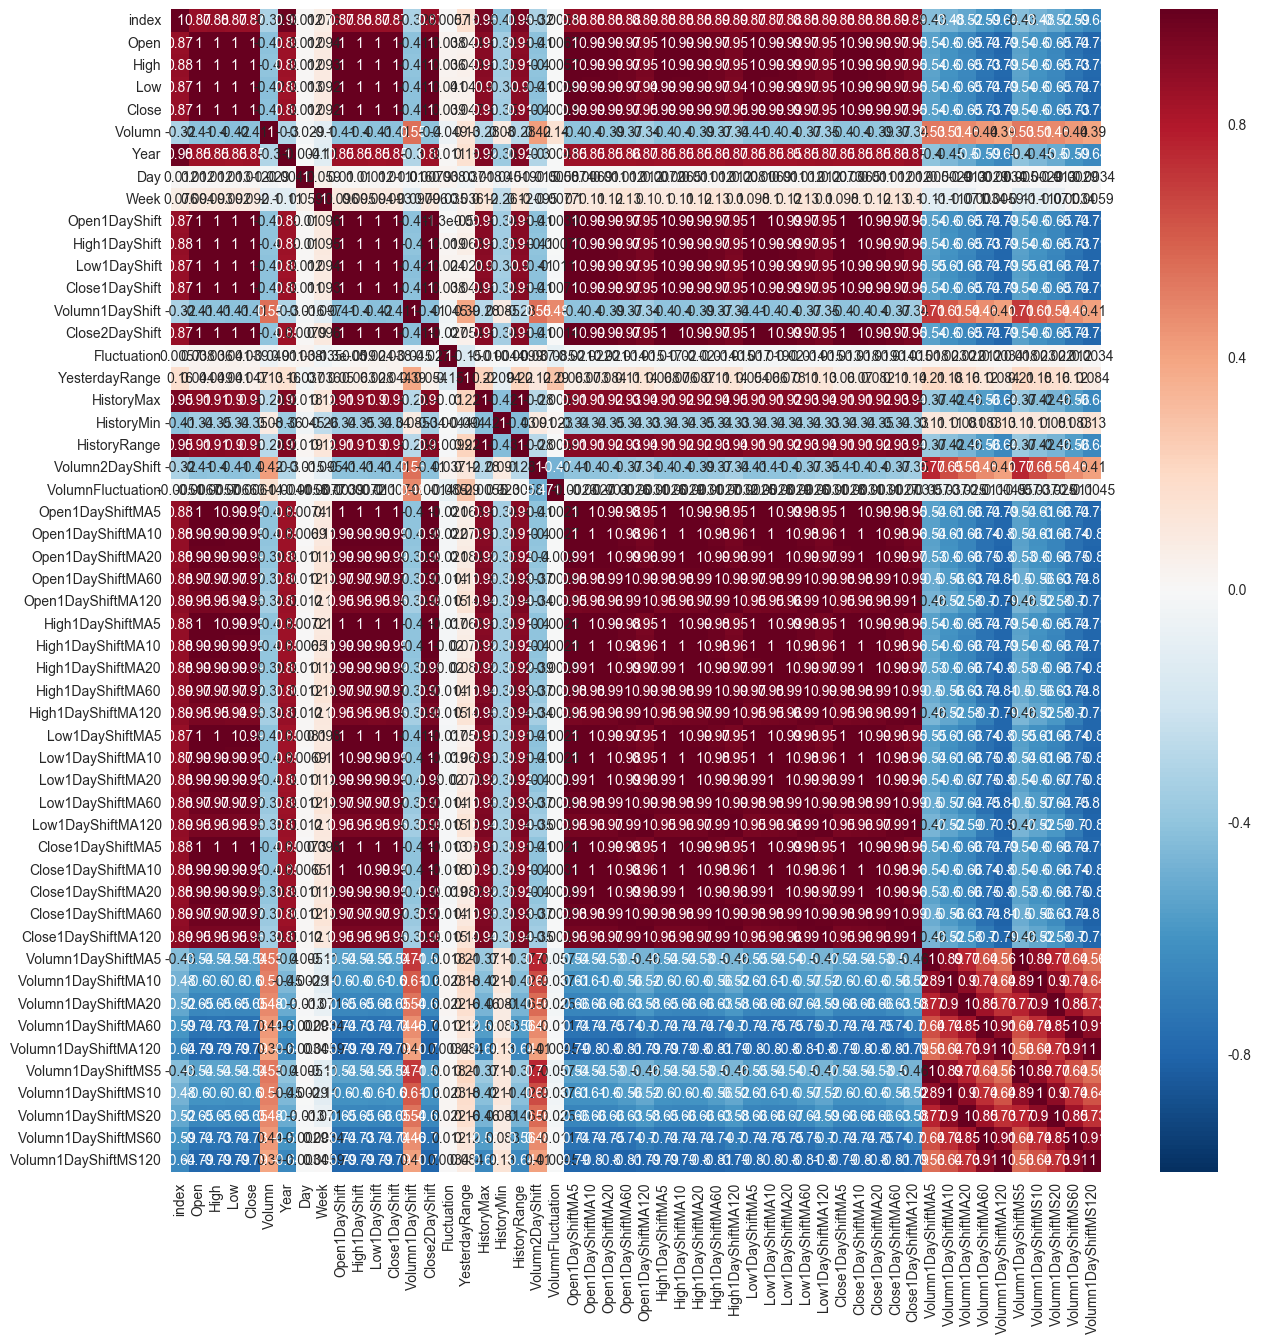

In [103]:
#View the correlation of the data
plt.figure(figsize=(15,15))
sns.heatmap(tetfp1.corr(),annot=True)

# Start To Machine Learning
Using Ridge model to do the prediction

In [104]:
#View the column of the data
tetfp1.columns

Index(['index', 'Code', 'Date', 'Company', 'Open', 'High', 'Low', 'Close',
       'Volumn', 'Year', 'Month', 'Day', 'Dayofwork', 'Week', 'Season',
       'Open1DayShift', 'High1DayShift', 'Low1DayShift', 'Close1DayShift',
       'Volumn1DayShift', 'Close2DayShift', 'Fluctuation', 'YesterdayRange',
       'RiseOrDown', 'HistoryMax', 'HistoryMin', 'HistoryRange',
       'HistoryRangeRise', 'YesterdayRangeRise', 'Volumn2DayShift',
       'VolumnFluctuation', 'VolumnRise', 'Open1DayShiftMA5',
       'Open1DayShiftMA10', 'Open1DayShiftMA20', 'Open1DayShiftMA60',
       'Open1DayShiftMA120', 'High1DayShiftMA5', 'High1DayShiftMA10',
       'High1DayShiftMA20', 'High1DayShiftMA60', 'High1DayShiftMA120',
       'Low1DayShiftMA5', 'Low1DayShiftMA10', 'Low1DayShiftMA20',
       'Low1DayShiftMA60', 'Low1DayShiftMA120', 'Close1DayShiftMA5',
       'Close1DayShiftMA10', 'Close1DayShiftMA20', 'Close1DayShiftMA60',
       'Close1DayShiftMA120', 'Volumn1DayShiftMA5', 'Volumn1DayShiftMA10',
       'Volu

In [105]:
#set the preditor and variable
predictor = tetfp1['Close']
variable = tetfp1[['Month','Dayofwork','Season','Open1DayShift','High1DayShift',
                   'Low1DayShift', 'Close1DayShift', 'Volumn1DayShift',
       'Close2DayShift', 'Fluctuation', 'YesterdayRange', 'RiseOrDown',
       'HistoryMax', 'HistoryMin', 'HistoryRange', 'HistoryRangeRise',
       'YesterdayRangeRise', 'Volumn2DayShift', 'VolumnFluctuation',
       'VolumnRise', 'Open1DayShiftMA5', 'Open1DayShiftMA10',
       'Open1DayShiftMA20', 'Open1DayShiftMA60', 'Open1DayShiftMA120',
       'High1DayShiftMA5', 'High1DayShiftMA10', 'High1DayShiftMA20',
       'High1DayShiftMA60', 'High1DayShiftMA120', 'Low1DayShiftMA5',
       'Low1DayShiftMA10', 'Low1DayShiftMA20', 'Low1DayShiftMA60',
       'Low1DayShiftMA120', 'Close1DayShiftMA5', 'Close1DayShiftMA10',
       'Close1DayShiftMA20', 'Close1DayShiftMA60', 'Close1DayShiftMA120',
       'Volumn1DayShiftMA5', 'Volumn1DayShiftMA10', 'Volumn1DayShiftMA20',
       'Volumn1DayShiftMA60', 'Volumn1DayShiftMA120', 'Volumn1DayShiftMS5',
       'Volumn1DayShiftMS10', 'Volumn1DayShiftMS20', 'Volumn1DayShiftMS60',
       'Volumn1DayShiftMS120']]

In [106]:
#Get the dummy data from some object column
variable_dummy = pd.get_dummies(variable)

In [107]:
#Seperate the data to the training set and testing set
from sklearn.cross_validation import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(variable_dummy, predictor)

In [108]:
#Ridge regression learning model
from sklearn.linear_model import Ridge
ridge = Ridge().fit(xtrain,ytrain)
print('Training set score:',ridge.score(xtrain,ytrain))
print('Test set score:',ridge.score(xtest,ytest))

Training set score: 0.995926857467
Test set score: 0.99565279683


# Tunning Model
Using the grid search method to find the best parameter of the model

In [109]:
#Set up the parameter grid
param_grid = {'alpha':[100,10,1,0.1,0.01,0.001,0.0001]}

In [110]:
#Import the grid search model
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(Ridge(),param_grid,cv=5)

In [111]:
#Seperate the data for finding the best parameter
xtrain_data, x_valid, ytrain_data, y_valid = train_test_split(xtrain,ytrain)

In [112]:
#Searching
grid_search.fit(x_valid,y_valid)

C:\Users\AdamChang\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.910682344210709e-17 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\AdamChang\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.052412894111171e-16 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\AdamChang\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.978540316178403e-18 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\AdamChang\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [113]:
#Show the score of the testing set
grid_search.score(xtest,ytest)

0.99548500649145855

In [114]:
#Show the best parameter and the best score in the searching
print('Best parameter:',grid_search.best_params_)
print('Best score:',grid_search.best_score_)

Best parameter: {'alpha': 100}
Best score: 0.993678224162


In [115]:
#Set up the parameter in the model
ridge100 = Ridge(alpha=100).fit(xtrain_data,ytrain_data)
print('Training set score:',ridge100.score(xtrain_data,ytrain_data))
print('Test set score:',ridge100.score(xtest,ytest))

Training set score: 0.995955433378
Test set score: 0.995922067426


In [116]:
#Check the RMSE
from sklearn.metrics import mean_squared_error
ridge_predict = ridge100.predict(variable_dummy)
mse = mean_squared_error(predictor, ridge_predict)
print('Root mean square error of the close price:',np.sqrt(mse))

Root mean square error of the close price: 0.574764039426


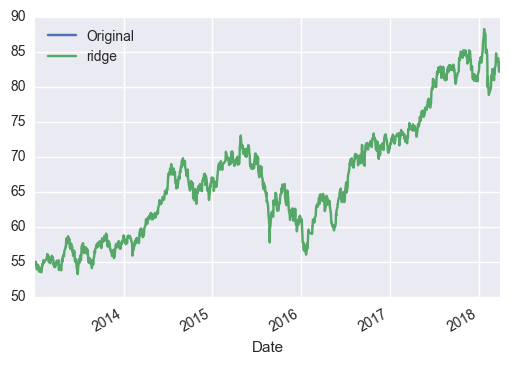

In [117]:
#Compare the prediction and the original data
output = pd.DataFrame({'Original':predictor,
                      'ridge':ridge_predict},index=tetfp1['Date'])

output.plot()

## Try to make the prediction of ETF price

In [118]:
#Get the Last data information
temp = variable_dummy.tail(1)

In [119]:
#Set the data
temp['Month_4'] = 1
temp['Month_3'] = 0
temp['Dayofwork_0'] = 1
temp['Dayofwork_5'] = 0

C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\AdamChang\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [120]:
#Check the data information
tetfp1.tail()

,index,Code,Date,Company,Open,High,Low,Close,Volumn,Year,Month,Day,Dayofwork,Week,Season,Open1DayShift,High1DayShift,Low1DayShift,Close1DayShift,Volumn1DayShift,Close2DayShift,Fluctuation,YesterdayRange,RiseOrDown,HistoryMax,HistoryMin,HistoryRange,HistoryRangeRise,YesterdayRangeRise,Volumn2DayShift,VolumnFluctuation,VolumnRise,Open1DayShiftMA5,Open1DayShiftMA10,Open1DayShiftMA20,Open1DayShiftMA60,Open1DayShiftMA120,High1DayShiftMA5,High1DayShiftMA10,High1DayShiftMA20,High1DayShiftMA60,High1DayShiftMA120,Low1DayShiftMA5,Low1DayShiftMA10,Low1DayShiftMA20,Low1DayShiftMA60,Low1DayShiftMA120,Close1DayShiftMA5,Close1DayShiftMA10,Close1DayShiftMA20,Close1DayShiftMA60,Close1DayShiftMA120,Volumn1DayShiftMA5,Volumn1DayShiftMA10,Volumn1DayShiftMA20,Volumn1DayShiftMA60,Volumn1DayShiftMA120,Volumn1DayShiftMS5,Volumn1DayShiftMS10,Volumn1DayShiftMS20,Volumn1DayShiftMS60,Volumn1DayShiftMS120
1282,1282,50,2018-03-28,元大台灣50,82.90,82.90,82.20,82.25,4161.0,2018,3,28,2,13,1,83.00,83.40,82.95,83.40,3277.0,82.20,1.20,0.45,1,88.3,53.0,35.3,0,-1,4369.0,-1092.0,-1,82.90,83.370,82.8350,83.241667,83.258333,83.34,83.755,83.2500,83.648333,83.579583,82.68,83.105,82.5825,82.948333,82.956667,83.02,83.520,82.9925,83.373333,83.298333,4845.0,4158.6,4829.10,5547.200000,4563.991667,24225.0,41586.0,96582.0,332832.0,547679.0
1283,1283,50,2018-03-29,元大台灣50,82.25,82.35,81.80,82.10,4099.0,2018,3,29,3,13,1,82.90,82.90,82.20,82.25,4161.0,83.40,-1.15,0.70,-1,88.3,53.0,35.3,0,1,3277.0,884.0,1,82.72,83.225,82.8250,83.276667,83.277500,83.10,83.600,83.2350,83.674167,83.596250,82.40,82.925,82.5750,82.973333,82.970417,82.70,83.315,82.9875,83.389167,83.311250,4699.0,4233.2,4654.00,5589.150000,4546.650000,23495.0,42332.0,93080.0,335349.0,545598.0
1284,1284,50,2018-03-30,元大台灣50,82.65,83.05,82.65,82.85,4994.0,2018,3,30,4,13,1,82.25,82.35,81.80,82.10,4099.0,82.25,-0.15,0.55,-1,88.3,53.0,35.3,0,-1,4161.0,-62.0,-1,82.37,83.050,82.8600,83.292500,83.290000,82.65,83.405,83.2550,83.687500,83.609167,82.07,82.715,82.6075,82.981667,82.982917,82.41,83.100,83.0050,83.400000,83.325417,4833.0,4292.5,4641.75,5640.766667,4523.316667,24165.0,42925.0,92835.0,338446.0,542798.0
1285,1285,50,2018-03-31,元大台灣50,82.85,83.05,82.75,82.95,878.0,2018,3,31,5,13,1,82.65,83.05,82.65,82.85,4994.0,82.10,0.75,0.40,1,88.3,53.0,35.3,0,-1,4099.0,895.0,1,82.53,82.915,82.9500,83.312500,83.308333,82.78,83.290,83.3475,83.714167,83.629167,82.24,82.670,82.7175,83.017500,83.002500,82.56,82.995,83.0900,83.436667,83.343750,4180.0,4240.9,4578.35,5681.033333,4536.241667,20900.0,42409.0,91567.0,340862.0,544349.0
1286,1285,50,2018-03-31,元大台灣50,82.85,83.05,82.75,82.95,878.0,2018,3,31,5,13,1,82.85,83.05,82.75,82.95,878.0,82.85,0.10,0.30,1,88.3,53.0,35.3,0,-1,4994.0,-4116.0,-1,82.73,82.835,83.0375,83.350000,83.323750,82.95,83.185,83.4250,83.750000,83.644583,82.47,82.600,82.8225,83.054167,83.018333,82.71,82.905,83.2000,83.470833,83.358333,3481.8,4125.2,4436.10,5635.666667,4530.350000,17409.0,41252.0,88722.0,338140.0,543642.0


In [121]:
#Set up the predictor
predictOpen = tetfp1['Open']
predictHigh = tetfp1['High']
predictLow = tetfp1['Low']
predictVolumn = tetfp1['Volumn']

In [122]:
#Predict the price
print('Close price:',ridge100.predict(temp))

ridgeOpen = Ridge(alpha=100).fit(variable_dummy,predictOpen)
print('Open price:',ridgeOpen.predict(temp))

ridgeHigh = Ridge(alpha=100).fit(variable_dummy,predictHigh)
print('High price:',ridgeHigh.predict(temp))

ridgeLow = Ridge(alpha=100).fit(variable_dummy,predictLow)
print('Low price:',ridgeLow.predict(temp))

ridgeVolumn = Ridge(alpha=100).fit(variable_dummy,predictVolumn)
print('Volumn price:',ridgeVolumn.predict(temp))

Close price: [ 83.15618432]
Open price: [ 83.01248358]
High price: [ 83.39213199]
Low price: [ 82.63422876]
Volumn price: [ 4011.23459624]
